In [ ]:
from datasets import load_dataset

In [ ]:
import pandas as pd

In [ ]:
ds = load_dataset(
    "koliskos/fake_news",
    data_files={"fake": "Fake.csv", "true": "True.csv"}
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
print(ds)
print(ds.keys())

DatasetDict({
    fake: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 23481
    })
    true: Dataset({
        features: ['title', 'text', 'subject', 'date'],
        num_rows: 21417
    })
})
dict_keys(['fake', 'true'])


In [ ]:
df_fake = ds["fake"].to_pandas()
df_true = ds["true"].to_pandas()

df_fake["label"] = 0   # Fake news
df_true["label"] = 1   # True news

print("Fake labels:\n", df_fake["label"].value_counts())
print("True labels:\n", df_true["label"].value_counts())

Fake labels:
 label
0    23481
Name: count, dtype: int64
True labels:
 label
1    21417
Name: count, dtype: int64


In [ ]:
df = pd.concat([df_fake, df_true], ignore_index=True)

print("Final dataset shape:", df.shape)
print(df["label"].value_counts())

Final dataset shape: (44898, 5)
label
0    23481
1    21417
Name: count, dtype: int64


In [ ]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
import re

In [ ]:
def clean_text(text):
    text = "" if text is None else str(text)
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [ ]:
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")

df["content"] = df["title"] + " " + df["text"]
df["content_clean"] = df["content"].apply(clean_text)

df[["content_clean", "label"]].head()

,content_clean,label
0,ben stein calls out th circuit court committed...,0
1,trump drops steve bannon from national securit...,1
2,puerto rico expects u s to lift jones act ship...,1
3,oops trump just accidentally confirmed he leak...,0
4,donald trump heads for scotland to reopen a go...,1


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2,
    max_df=0.95
)

X = tfidf.fit_transform(df["content_clean"])
y = df["label"]

print(X.shape)

(44898, 20000)


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

In [ ]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english",
    min_df=2,
    max_df=0.95
)

X = tfidf.fit_transform(df["content_clean"])
y = df["label"]

print(X.shape)

(44898, 50000)


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape[0])
print("Test :", X_test.shape[0])


Train: 35918
Test : 8980


In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

models = {
    "Naive Bayes (MNB)": MultinomialNB(alpha=0.5),
    "Logistic Regression": LogisticRegression(
        max_iter=4000,
        solver="liblinear",
        C=1.0,
        class_weight="balanced"
    ),
    "Linear SVM (LinearSVC)": LinearSVC(
        C=1.0,
        class_weight="balanced"
    )
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    print("Trained:", name)


Trained: Naive Bayes (MNB)
Trained: Logistic Regression
Trained: Linear SVM (LinearSVC)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    RocCurveDisplay,
    PrecisionRecallDisplay,
    accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    classification_report
)

def get_scores(clf, X):
    """
    Returns continuous scores for ROC / PR curves.
    """
    if hasattr(clf, "predict_proba"):
        return clf.predict_proba(X)[:, 1]
    else:
        return clf.decision_function(X)


In [ ]:
results = []

for name, clf in models.items():
    y_pred = clf.predict(X_test)
    y_scores = get_scores(clf, X_test)

    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_scores)
    pr  = average_precision_score(y_test, y_scores)

    results.append({
        "model": name,
        "accuracy": acc,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr
    })

    print("\n" + "="*70)
    print(f"MODEL: {name}")
    print("Accuracy:", round(acc, 4))
    print("F1 Score:", round(f1, 4))
    print("ROC-AUC :", round(roc, 4))
    print("PR-AUC  :", round(pr, 4))
    print("\nClassification Report:\n",
          classification_report(y_test, y_pred, digits=4))



MODEL: Naive Bayes (MNB)
Accuracy: 0.9584
F1 Score: 0.9563
ROC-AUC : 0.9907
PR-AUC  : 0.9893

Classification Report:
               precision    recall  f1-score   support

           0     0.9590    0.9615    0.9602      4696
           1     0.9576    0.9549    0.9563      4284

    accuracy                         0.9584      8980
   macro avg     0.9583    0.9582    0.9583      8980
weighted avg     0.9584    0.9584    0.9583      8980


MODEL: Logistic Regression
Accuracy: 0.9884
F1 Score: 0.9879
ROC-AUC : 0.9993
PR-AUC  : 0.9992

Classification Report:
               precision    recall  f1-score   support

           0     0.9929    0.9849    0.9889      4696
           1     0.9836    0.9923    0.9879      4284

    accuracy                         0.9884      8980
   macro avg     0.9882    0.9886    0.9884      8980
weighted avg     0.9885    0.9884    0.9884      8980


MODEL: Linear SVM (LinearSVC)
Accuracy: 0.9958
F1 Score: 0.9956
ROC-AUC : 0.9999
PR-AUC  : 0.9999

Classi

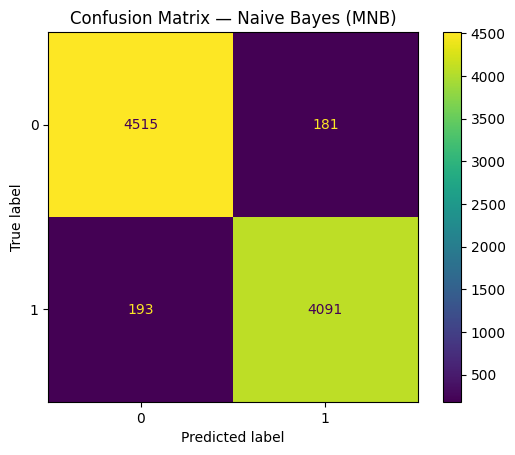

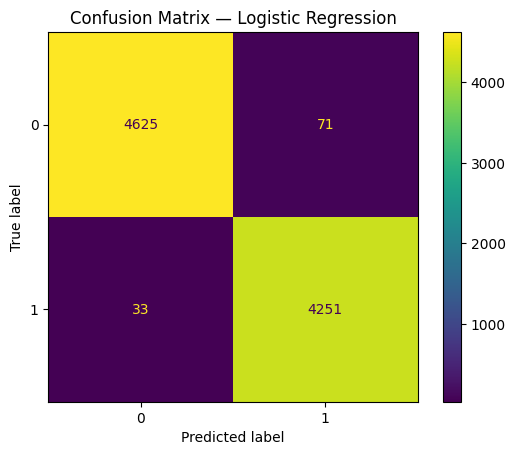

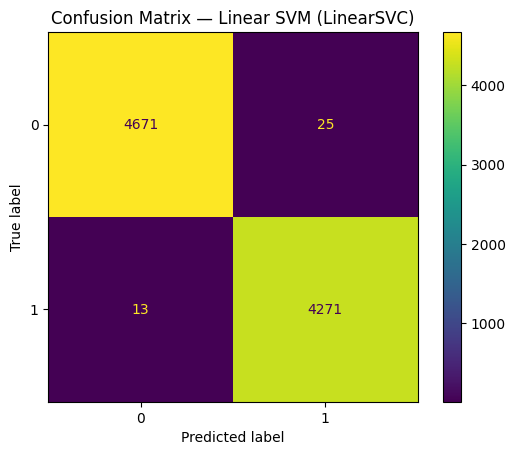

In [ ]:
for name, clf in models.items():
    y_pred = clf.predict(X_test)

    fig, ax = plt.subplots()
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        values_format="d"
    )
    ax.set_title(f"Confusion Matrix — {name}")
    plt.show()


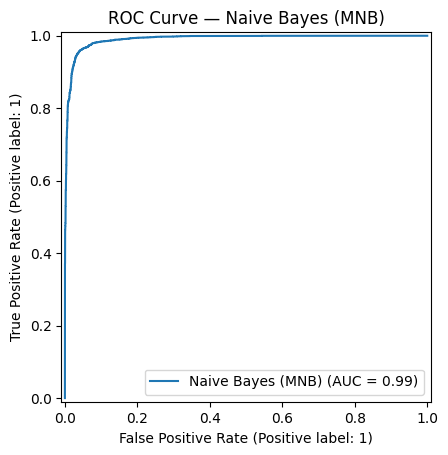

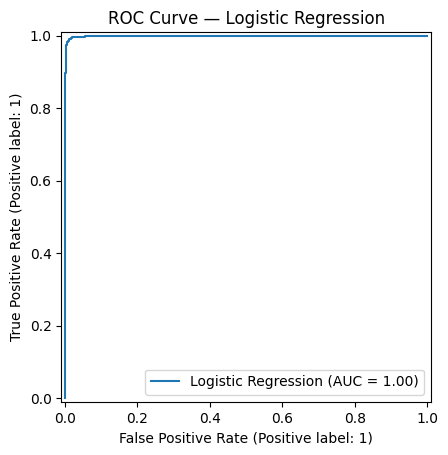

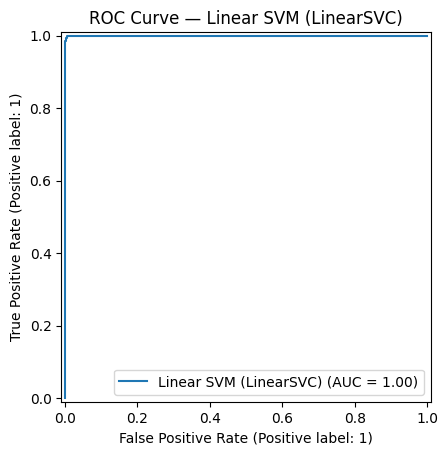

In [ ]:
for name, clf in models.items():
    y_scores = get_scores(clf, X_test)

    fig, ax = plt.subplots()
    RocCurveDisplay.from_predictions(
        y_test,
        y_scores,
        ax=ax,
        name=name
    )
    ax.set_title(f"ROC Curve — {name}")
    plt.show()


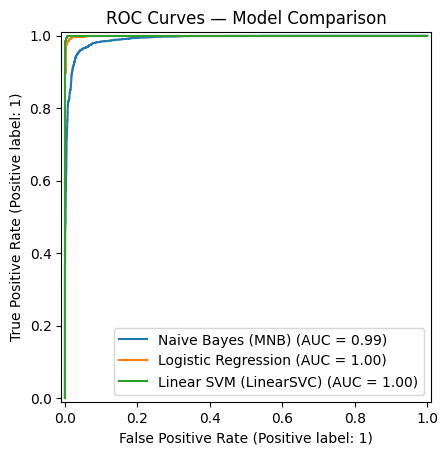

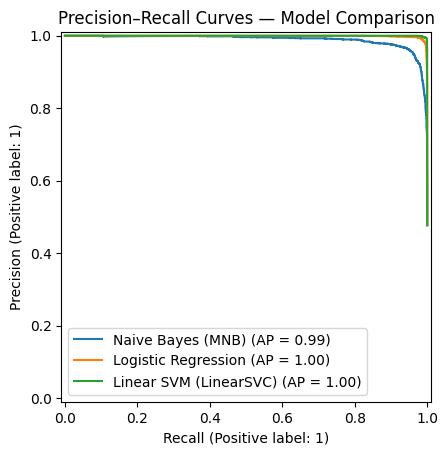

In [ ]:
# Combined ROC
fig, ax = plt.subplots()
for name, clf in models.items():
    y_scores = get_scores(clf, X_test)
    RocCurveDisplay.from_predictions(y_test, y_scores, ax=ax, name=name)
ax.set_title("ROC Curves — Model Comparison")
plt.show()

# Combined PR
fig, ax = plt.subplots()
for name, clf in models.items():
    y_scores = get_scores(clf, X_test)
    PrecisionRecallDisplay.from_predictions(y_test, y_scores, ax=ax, name=name)
ax.set_title("Precision–Recall Curves — Model Comparison")
plt.show()


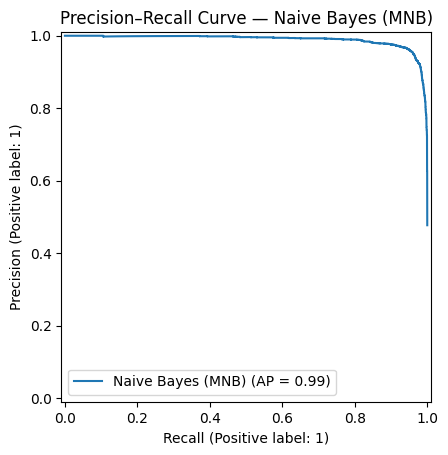

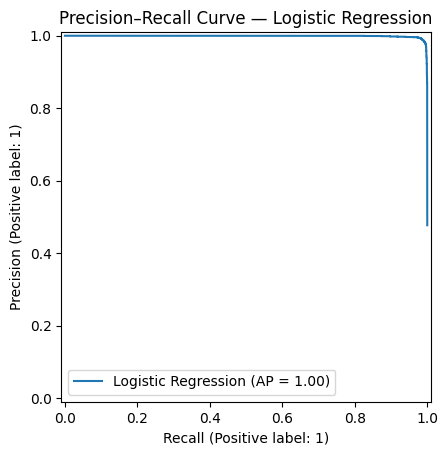

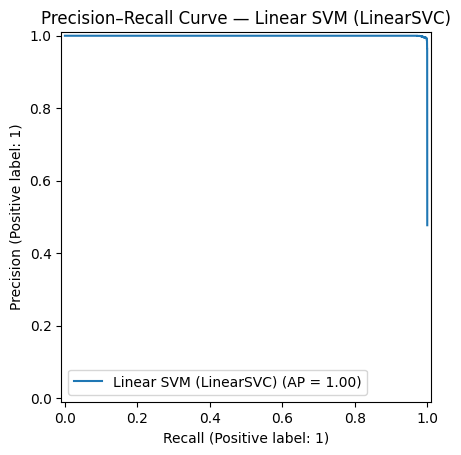

In [ ]:
for name, clf in models.items():
    y_scores = get_scores(clf, X_test)

    fig, ax = plt.subplots()
    PrecisionRecallDisplay.from_predictions(
        y_test,
        y_scores,
        ax=ax,
        name=name
    )
    ax.set_title(f"Precision–Recall Curve — {name}")
    plt.show()


,model,accuracy,f1,roc_auc,pr_auc
0,Naive Bayes (MNB),0.958352,0.956288,0.990720,0.989293
1,Logistic Regression,0.988419,0.987915,0.999262,0.999200
2,Linear SVM (LinearSVC),0.995768,0.995571,0.999910,0.999902


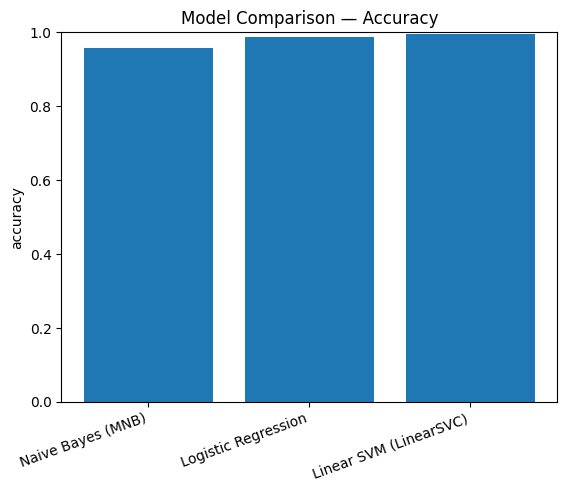

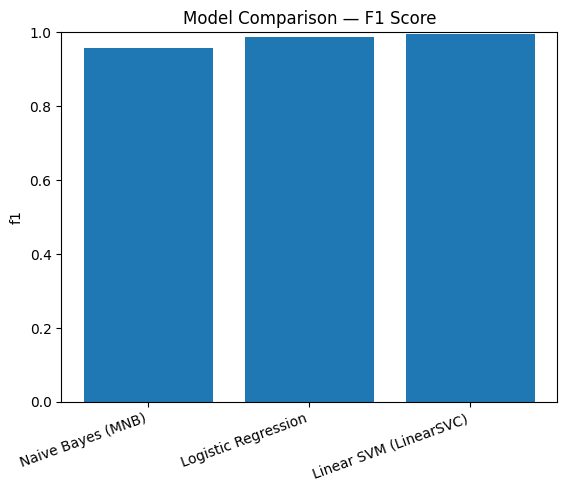

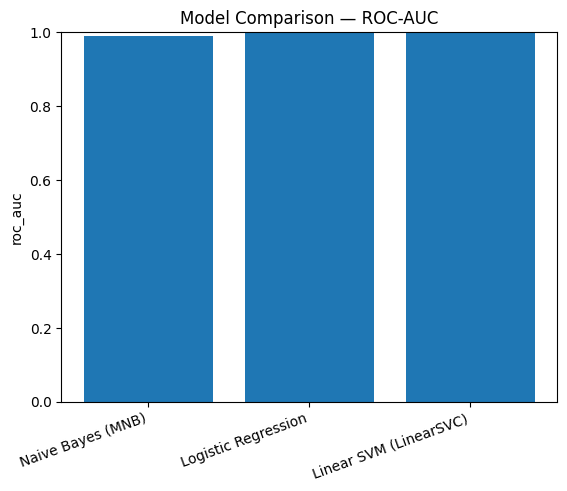

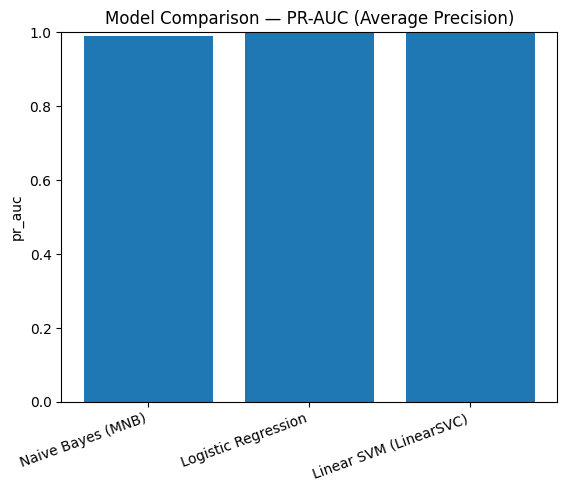

In [ ]:
import pandas as pd

res_df = pd.DataFrame(results)
display(res_df)

def bar_plot(metric, title):
    fig, ax = plt.subplots()
    ax.bar(res_df["model"], res_df[metric])
    ax.set_ylim(0, 1)
    ax.set_title(title)
    ax.set_ylabel(metric)
    plt.xticks(rotation=20, ha="right")
    plt.show()

bar_plot("accuracy", "Model Comparison — Accuracy")
bar_plot("f1", "Model Comparison — F1 Score")
bar_plot("roc_auc", "Model Comparison — ROC-AUC")
bar_plot("pr_auc", "Model Comparison — PR-AUC (Average Precision)")


,model,train_time_seconds
0,Naive Bayes (MNB),0.053378
2,Linear SVM (LinearSVC),0.762619
1,Logistic Regression,2.214795


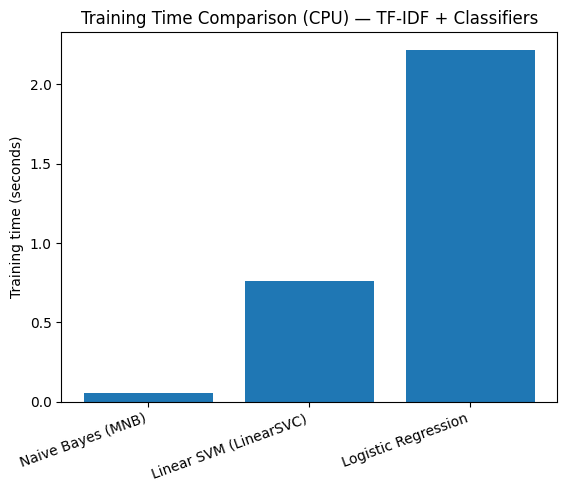

In [ ]:
import time
import pandas as pd
import matplotlib.pyplot as plt

timing_rows = []

for name, clf in models.items():
    start = time.perf_counter()
    clf.fit(X_train, y_train)
    end = time.perf_counter()

    timing_rows.append({
        "model": name,
        "train_time_seconds": end - start
    })

timing_df = pd.DataFrame(timing_rows).sort_values("train_time_seconds")
display(timing_df)

# Bar chart (one figure, clean for report)
fig, ax = plt.subplots()
ax.bar(timing_df["model"], timing_df["train_time_seconds"])
ax.set_title("Training Time Comparison (CPU) — TF-IDF + Classifiers")
ax.set_ylabel("Training time (seconds)")
plt.xticks(rotation=20, ha="right")
plt.show()


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
from sklearn.model_selection import train_test_split

# 64 / 16 / 20 split
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp,
    y_train_temp,
    test_size=0.20,
    random_state=42,
    stratify=y_train_temp
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train: (28734, 50000)
Val  : (7184, 50000)
Test : (8980, 50000)
